## RUN Initial trials round of metadynamics

In [1]:
%%bash
cd initial_trial

for i in {2..4}
do 
    cp -r initial_trial_1 initial_trial_$i
done

In [1]:
# %%bash
# pwd

# module load gromacs/2019.4

# cd initial_trial

# for i in {1..4}
# do 
#     cd initial_trial_$i
#     pwd
#     # gmx_mpi grompp -f step5_production.mdp -o md.tpr -c step5_0.gro -p topol.top -n index.ndx -maxwarn 4
#     # gmx_mpi mdrun -v -deffnm md --plumed plumed_initial.dat -cpi md.cpt -ntomp 1
#     cd ../
# done



/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO
Loading gromacs/2019.4/gcc/8.4.0/openmpi/3.1.5/zen
  Loading requirement: gcc/8.4.0 openmpi/3.1.5/gcc/8.4.0/zen
    plumed/2.6.0/gcc/8.4.0/openmpi/3.1.5/zen
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/initial_trial1


In [4]:
%%bash
pwd

module load gromacs/2019.4

cd initial_trial

for i in {1..4}
do 
    cd initial_trial_$i
    pwd
    sbatch job.sh
    cd ../
done



/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO
Loading gromacs/2019.4/gcc/8.4.0/openmpi/3.1.5/zen
  Loading requirement: gcc/8.4.0 openmpi/3.1.5/gcc/8.4.0/zen
    plumed/2.6.0/gcc/8.4.0/openmpi/3.1.5/zen
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/initial_trial/initial_trial_1
Submitted batch job 4329638
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/initial_trial/initial_trial_2
Submitted batch job 4329639
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/initial_trial/initial_trial_3
Submitted batch job 4329640
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/initial_trial/initial_trial_4
Submitted batch job 4329641


In [7]:
!pwd
%ls

/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO
01_metaD/    data/               initial_trial/       SPIB_scripts/
02_inMetaD/  google_colab.ipynb  plumed_generator.py


## Select appropriate OPs for SPIB tranining 

In [18]:
%cd SPIB01

/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/SPIB01


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import importlib.util
from sklearn.cluster import KMeans
from itertools import groupby
import sys
import os
if not os.path.exists('data/'):
    os.mkdir('data')

In [21]:
data_list=[]
data_list_str=[]

for i in range(1,5):
    locals()['metaD{0}'.format(i)] = np.loadtxt('../initial_trial/initial_trial_%i/COLVAR'%(i))
    data_list.append(locals()['metaD{0}'.format(i)])
    data_list_str.append('metaD{0}'.format(i))



(36948, 32)
(29343, 32)
(27456, 32)
(31726, 32)


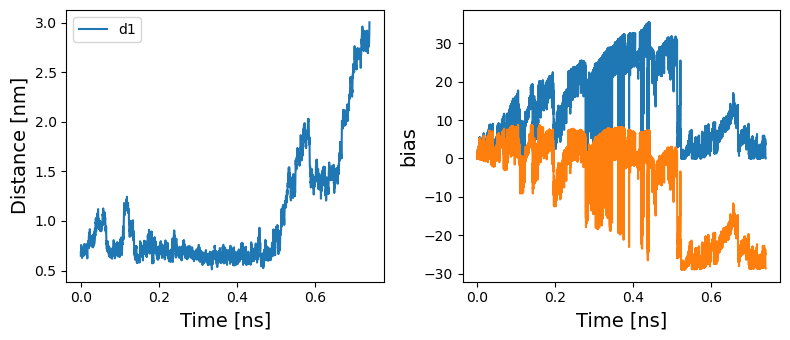

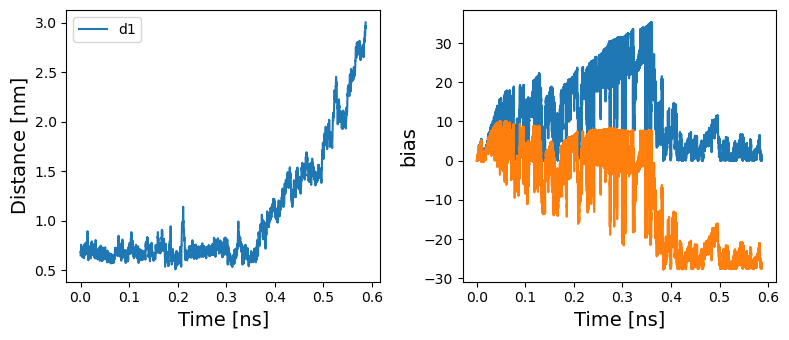

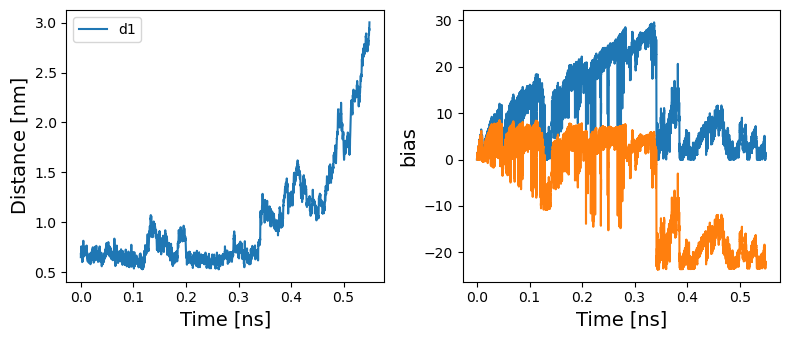

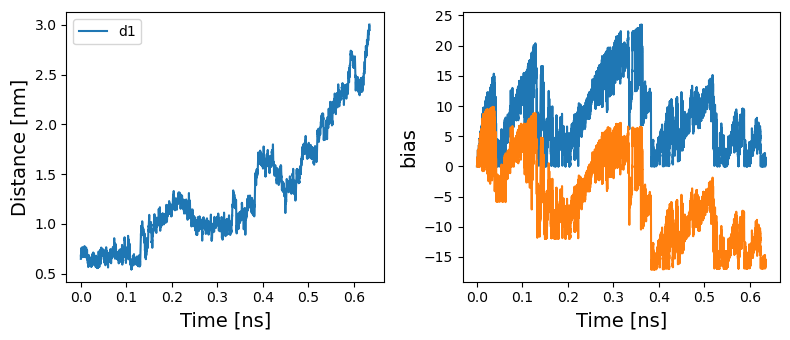

In [53]:
# visualize the data and also initiate K-mean Clustering +Labeling
for i, simulation_data in enumerate(data_list): 

    print(simulation_data.shape)

    distance = simulation_data[:,[0,-3]] # take time and the 426th colums of data that correspond to the distance
    bias = simulation_data[:,[-2,-1]] 
    bias_distance = simulation_data[:,[0,-4]] 
    traj_raw = simulation_data[:,[-3,-4]]

    
    plt.figure(figsize=(8,3.5))
    time = bias_distance[:,0]/1000
    
    plt.subplot(1,2,1)
    # plot distance between the COM on ligand and COM on protein to observe the dissociation
    plt.plot(time,distance[:,1],label='d1')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('Distance [nm]',fontsize=14)
#     plt.title('distance between COM on ligand and protein')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(time,bias[:,0],label='bias')
    plt.plot(time,bias[:,1],label='rbias')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('bias',fontsize=14)
    plt.tight_layout()

    ######
    # One-hot encoded initial state assignment: Using K-mean clustering
    ######
    num_labels = 20
    data = list(zip(traj_raw[:,0],traj_raw[:,1]))
    kmeans = KMeans(n_clusters= num_labels , random_state=0).fit(data)

    one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
    one_hot_labels[np.arange(traj_raw.shape[0]),kmeans.labels_] = 1
    file_name = data_list_str[i]

    # Save one-hot encoded initial states
    np.save('data/labels_'+str(file_name)+'.npy', one_hot_labels)

    # Create and save all 425 different OP as an SPIB input with normalization
    FKBP_distance_mean = np.mean(simulation_data[:,1:29], axis=0)
    FKBP_distance_std = np.std(simulation_data[:,1:29], axis=0)

    np.save('data/FKBP_distance_data_mean.npy', FKBP_distance_mean)    
    np.save('data/FKBP_distance_data_std.npy', FKBP_distance_std)  

    distance_simulation_data = simulation_data[:,1:29] 
    
    traj_path_SPIB_OP = (distance_simulation_data-FKBP_distance_mean)/FKBP_distance_std #normalized trajectory data
    np.save('data/normalized_traj_path_'+str(file_name)+'.npy', traj_path_SPIB_OP)

# Combine all SPIB output data files for all 4 trajectories
concatenate_data = np.concatenate(data_list, axis=0)[:,1:29]

concatenate_data_mean = np.mean(concatenate_data, axis=0)
concatenate_data_std = np.std(concatenate_data, axis=0)

np.save('data/FKBP_distance_data_mean.npy', concatenate_data_mean)    
np.save('data/FKBP_distance_data_std.npy', concatenate_data_std)  
    

## RUN SPIB stage 1

In [27]:
# # run SPIB with the selected hyperparameters in the sample_config.ini files on here 6 trajectories 
!python SPIB_scripts/test_model_advanced.py -config data/sample_config.ini


Iteration 500:	Time 0.975430 s
Loss (train) 2.996149	KL loss (train): 2.975278
Reconstruction loss (train) 2.995851
Loss (test) 2.987748	KL loss (test): 2.790190
Reconstruction loss (test) 2.987469
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1645, 0.0000,
        0.2292, 0.0000, 0.0000, 0.6063, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.614576
Update lr to 0.000010
Epoch: 1

Iteration 1000:	Time 2.142458 s
Loss (train) 2.978139	KL loss (train): 2.949973
Reconstruction loss (train) 2.977844
Loss (test) 2.974790	KL loss (test): 3.389281
Reconstruction loss (test) 2.974451
Iteration 1500:	Time 3.112534 s
Loss (train) 2.943756	KL loss (train): 4.980940
Reconstruction loss (train) 2.943258
Loss (test) 2.983935	KL loss (test): 3.808753
Reconstruction loss (test) 2.983554
tensor([0.0000, 0.0000, 0.0355, 0.0053, 0.0000, 0.0000, 0.0000, 0.2196, 0.0000,
        0.6478, 0.0000, 0.0000, 0.0891, 0.0000, 0.0027, 0.0000, 0.0000, 0.

tensor([0.0000, 0.0000, 0.0000, 0.1565, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6428, 0.0000,
        0.0000, 0.2007])
State population change=0.013448
Update lr to 0.000010
Update 2

Epoch: 0

Iteration 12000:	Time 26.432094 s
Loss (train) 0.651416	KL loss (train): 18.442345
Reconstruction loss (train) 0.649571
Loss (test) 0.564652	KL loss (test): 18.078596
Reconstruction loss (test) 0.562845
Iteration 12500:	Time 27.366128 s
Loss (train) 0.535459	KL loss (train): 19.544338
Reconstruction loss (train) 0.533505
Loss (test) 0.570356	KL loss (test): 18.516169
Reconstruction loss (test) 0.568504
tensor([0.0000, 0.0000, 0.0000, 0.1634, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6400, 0.0000,
        0.0000, 0.1966])
State population change=0.008421
Update lr to 0.000010
Epoch: 1

Iteration 13000:	Time 28.490260 s
Loss (train) 0.588620	KL loss (train): 19.141693
R

Iteration 23500:	Time 51.245974 s
Loss (train) 0.311054	KL loss (train): 20.256016
Reconstruction loss (train) 0.309029
Loss (test) 0.283985	KL loss (test): 20.419439
Reconstruction loss (test) 0.281943
tensor([0.0000, 0.0000, 0.0000, 0.1890, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6152, 0.0000,
        0.0000, 0.1958])
State population change=0.000986
Update lr to 0.000010
Epoch: 2

Iteration 24000:	Time 52.369186 s
Loss (train) 0.317012	KL loss (train): 19.718403
Reconstruction loss (train) 0.315040
Loss (test) 0.364963	KL loss (test): 21.397459
Reconstruction loss (test) 0.362823
Iteration 24500:	Time 53.300247 s
Loss (train) 0.356641	KL loss (train): 22.042898
Reconstruction loss (train) 0.354436
Loss (test) 0.325609	KL loss (test): 21.466768
Reconstruction loss (test) 0.323462
tensor([0.0000, 0.0000, 0.0000, 0.1896, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

### Hyperparameters for SPIB 



In [28]:
# # hyperparameters

# ## Selected hyperparameters to train an SPIB model
# dt = 1000
# rc_dim = 2 
# num_labels = 20
# encoder_type = 'Linear' 
# neuron_num1 =  32 
# neuron_num2 =64
# ## heuristic for batch size is to set it ~ 0.1% of the trajectory length
# batch_size = 128 
# learning_rate = 0.00001
# beta = 0.0001  
# seed = 0 
# SPIB_OPs = 28
# Weighted_or_not = "Unweighted"



In [31]:
# number_states=[]
# ps = dt*0.05
# ## Number of trajectories in this analysis
# num_traj = 3
# ## Construct file path from chosen hyperparameter values
# path = "SPIB/" + Weighted_or_not + "_d=" + str(rc_dim) + "_t=" + str(dt) + "_b=" + "{:.4f}".format(beta) + "_learn=" + "{:.6f}".format(learning_rate)
# one_hot_converged_labels = np.load(path + "_traj" + str(num_traj-1) + "_labels" + str(seed) + ".npy")
# traj_rc = np.load(path + "_traj" + str(num_traj-1) + "_mean_representation"+ str(seed) + ".npy")

# converged_labels = np.zeros((one_hot_converged_labels.shape[0]), dtype = 'int')
# for i in range(converged_labels.shape[0]):
#   converged_labels[i] = np.nonzero(one_hot_converged_labels[i,:])[0]

# plt.figure(figsize = (6,5))
# plt.scatter(traj_rc[:,0], traj_rc[:,1] , c=converged_labels, s=5, alpha=.5)
# plt.title('RC at %2.2f ps'%ps,fontsize=14)
# plt.xlabel(' $RC_0$',fontsize=14)
# plt.ylabel(' $RC_1$',fontsize=14)
# cb = plt.colorbar()
# cb.set_label('frame density',fontsize=14)

# plt.plot(traj_rc[0,0],traj_rc[0,1],marker='*',markersize=5,color='red')
# plt.tight_layout()


## Generate Plume file from learn RC for MetaD

In [70]:
!pwd

/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/SPIB01


In [75]:
!python plumed_generator.py

===== First updated sigma for RC 1 and RC2 ======
[sigma_1,sigma_2] =  [0.17808285 0.17553604]


In [76]:
!mv data/plumed_metaD_ANN.dat ../01_metaD/01_metaD1

## Prepare for first SPIB stage of metadynmaics 

In [77]:
%%bash

cd ../01_metaD

for i in {2..4}
do 
    cp -r 01_metaD1 01_metaD$i
done


pwd

for i in {1..4}
do 
    cd 01_metaD$i
    pwd
    sbatch job.sh
    # gmx_mpi grompp -f step5_production.mdp -o md.tpr -c step5_0.gro -p topol.top -n index.ndx -maxwarn 4
    # gmx_mpi mdrun -v -deffnm md --plumed plumed_initial.dat -cpi md.cpt -ntomp 1
    cd ../
done

/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/02_inMetaD
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/02_inMetaD/02_inMetaD1
Submitted batch job 4329745
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/02_inMetaD/02_inMetaD2
Submitted batch job 4329746
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/02_inMetaD/02_inMetaD3
Submitted batch job 4329747
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/02_inMetaD/02_inMetaD4
Submitted batch job 4329748


In [86]:
!pwd
%cd ../SPIB02

/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/SPIB01
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/SPIB02


In [88]:
data_list=[]
data_list_str=[]

for i in range(1,5):
    locals()['metaD{0}'.format(i)] = np.loadtxt('../01_metaD/01_metaD%i/COLVAR_round_1'%(i))
    data_list.append(locals()['metaD{0}'.format(i)])
    data_list_str.append('metaD{0}'.format(i))



(21670, 35)
(16768, 35)
(16976, 35)
(28916, 35)


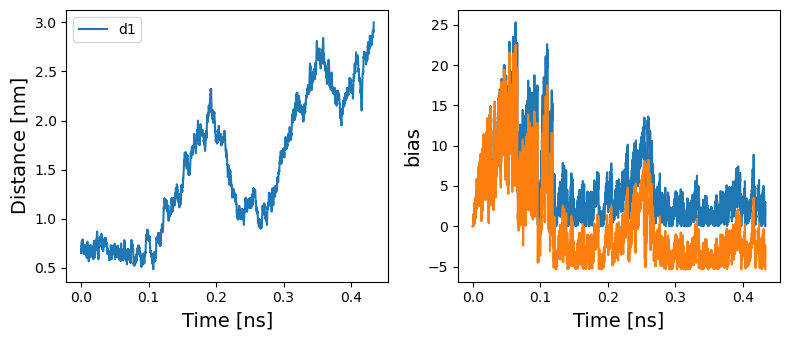

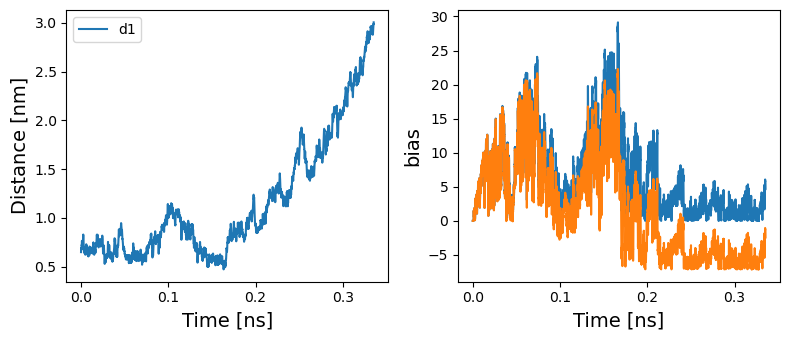

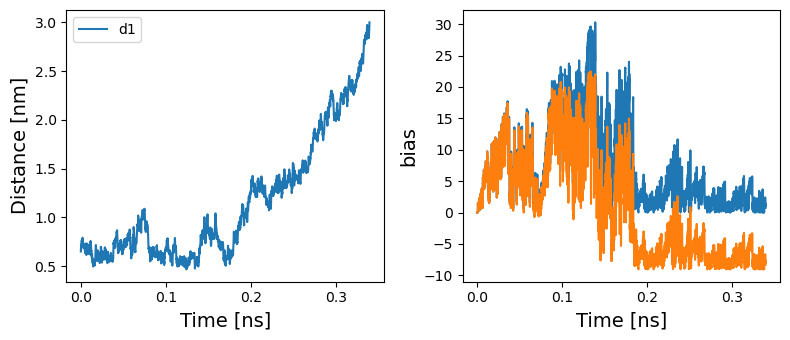

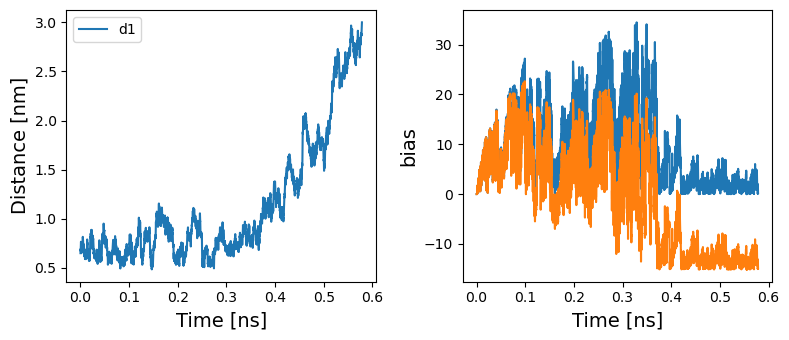

In [90]:
# visualize the data and also initiate K-mean Clustering +Labeling
for i, simulation_data in enumerate(data_list): 

    print(simulation_data.shape)

    distance = simulation_data[:,[0,-5]] # take time and the 426th colums of data that correspond to the distance
    bias = simulation_data[:,[-2,-1]] 
    bias_distance = simulation_data[:,[0,-5]] 
    traj_raw = simulation_data[:,[-4,-3]]
    
    plt.figure(figsize=(8,3.5))
    time = bias_distance[:,0]/1000
    
    plt.subplot(1,2,1)
    # plot distance between the COM on ligand and COM on protein to observe the dissociation
    plt.plot(time,distance[:,1],label='d1')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('Distance [nm]',fontsize=14)
#     plt.title('distance between COM on ligand and protein')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(time,bias[:,0],label='bias')
    plt.plot(time,bias[:,1],label='rbias')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('bias',fontsize=14)
    plt.tight_layout()
    

#     #####
#     One-hot encoded initial state assignment: Using K-mean clustering
#     #####
    num_labels = 20
    data = list(zip(traj_raw[:,0],traj_raw[:,1]))
    kmeans = KMeans(n_clusters= num_labels , random_state=0).fit(data)

    one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
    one_hot_labels[np.arange(traj_raw.shape[0]),kmeans.labels_] = 1
    file_name = data_list_str[i]

    # Save one-hot encoded initial states
    np.save('data/labels_'+str(file_name)+'.npy', one_hot_labels)

    # Create and save all 425 different OP as an SPIB input with normalization
    FKBP_distance_mean = np.mean(simulation_data[:,1:29], axis=0)
    FKBP_distance_std = np.std(simulation_data[:,1:29], axis=0)

    np.save('data/FKBP_distance_data_mean.npy', FKBP_distance_mean)    
    np.save('data/FKBP_distance_data_std.npy', FKBP_distance_std)  

    distance_simulation_data = simulation_data[:,1:29] 
    
    traj_path_SPIB_OP = (distance_simulation_data-FKBP_distance_mean)/FKBP_distance_std #normalized trajectory data
    np.save('data/normalized_traj_path_'+str(file_name)+'.npy', traj_path_SPIB_OP)


## RUN SPIB stage 2

In [95]:
# run SPIB with the selected hyperparameters in the sample_config.ini files on here 6 trajectories 
!python SPIB_scripts/test_model_advanced.py -config data/sample_config.ini


Iteration 500:	Time 0.996438 s
Loss (train) 3.001158	KL loss (train): 3.037269
Reconstruction loss (train) 3.000854
Loss (test) 2.996533	KL loss (test): 3.456272
Reconstruction loss (test) 2.996187
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000,
        0.0000, 0.0000, 0.0000, 0.9900, 0.0000, 0.0061, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.955992
Update lr to 0.000010
Epoch: 1

Iteration 1000:	Time 2.127274 s
Loss (train) 2.990664	KL loss (train): 3.963356
Reconstruction loss (train) 2.990268
Loss (test) 3.005070	KL loss (test): 3.704260
Reconstruction loss (test) 3.004700
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.9871, 0.0000, 0.0129, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.008432
Update lr to 0.000010
Epoch: 2

Iteration 1500:	Time 3.256438 s
Loss (train) 2.964071	KL loss (train): 3.728241
Reconstruction loss (tr

tensor([0.0000, 0.1569, 0.0000, 0.0000, 0.6452, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1979, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.004066
Update lr to 0.000008
Update 2

Epoch: 0

Iteration 10500:	Time 23.319512 s
Loss (train) 0.496595	KL loss (train): 19.208292
Reconstruction loss (train) 0.494674
Loss (test) 0.410563	KL loss (test): 17.384733
Reconstruction loss (test) 0.408825
tensor([0.0000, 0.2267, 0.0000, 0.0000, 0.6383, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1350, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.094148
Update lr to 0.000010
Epoch: 1

Iteration 11000:	Time 24.402038 s
Loss (train) 0.545993	KL loss (train): 20.761745
Reconstruction loss (train) 0.543917
Loss (test) 0.413141	KL loss (test): 17.768576
Reconstruction loss (test) 0.411364
tensor([0.0000, 0.2269, 0.0000, 0.0000, 0.6278, 0.0000, 0.0000, 0.0000, 0.0000,
    

Iteration 20000:	Time 44.857050 s
Loss (train) 0.313263	KL loss (train): 19.030046
Reconstruction loss (train) 0.311360
Loss (test) 0.258217	KL loss (test): 18.504194
Reconstruction loss (test) 0.256367
tensor([0.0000, 0.4084, 0.0000, 0.0000, 0.5916, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.006123
Update lr to 0.000010
Epoch: 2

Iteration 20500:	Time 45.947243 s
Loss (train) 0.283704	KL loss (train): 19.720860
Reconstruction loss (train) 0.281731
Loss (test) 0.301793	KL loss (test): 20.743874
Reconstruction loss (test) 0.299719
tensor([0.0000, 0.4107, 0.0000, 0.0000, 0.5893, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.003188
Update lr to 0.000010
Epoch: 3

Iteration 21000:	Time 47.035142 s
Loss (train) 0.318800	KL loss (train): 19.571968
Reconstruct

### Hyperparameters for SPIB

## Generate Plume file from learn RC for MetaD


In [96]:
!python plumed_generator_v2.py

===== Second updated sigma for RC 1 and RC2 ======
[sigma_1,sigma_2] =  [0.18754151 0.14112696]


In [97]:
!mv data/plumed_metaD_ANN.dat ../02_inMetaD/02_inMetaD1

In [102]:
!pwd

/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/SPIB02


## Prepare for Second SPIB stage/ Final infrequent metadynamics 

In [103]:

%%bash
cd ../02_inMetaD

# for i in {2..4}
# do 
#     cp -r 02_inMetaD1 02_inMetaD$i
# done

for i in {1..4}
do 
    cd 02_inMetaD$i
    pwd
    sbatch job.sh
    cd ../
done

# for i in {1..4}
# do 
#     cd 02_inMetaD$i
#     pwd
#     # gmx_mpi grompp -f step5_production.mdp -o md.tpr -c step5_0.gro -p topol.top -n index.ndx -maxwarn 4
#     # gmx_mpi mdrun -v -deffnm md --plumed plumed_initial.dat -cpi md.cpt -ntomp 1
#     cd ../
# done

/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/02_inMetaD/02_inMetaD1
Submitted batch job 4329802
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/02_inMetaD/02_inMetaD2
Submitted batch job 4329803
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/02_inMetaD/02_inMetaD3
Submitted batch job 4329804
/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/02_inMetaD/02_inMetaD4
Submitted batch job 4329805


In [106]:
!pwd

/scratch/zt1/project/tiwary-prj/user/sueminl/2022-10-14/FKBP/colab_DMSO/SPIB02


In [111]:
data_list_2=[]
data_list_str_2=[]

for i in range(1,4):
    locals()['inMetaD{0}'.format(i)] = np.loadtxt('../02_inMetaD/02_inMetaD%i/COLVAR_round_2'%(i))
    data_list_2.append(locals()['inMetaD{0}'.format(i)])
    data_list_str_2.append('inMetaD{0}'.format(i))



## Calculate residence time and curve fit

In [112]:
residence_t_data = []


# def residence_t():

# Loop over the data points in 'data_list'
for i in range(len(data_list)):
    simulation_data = data_list[i]
    # Extract the time and bias columns from the simulation data
    time = simulation_data[:,0]
    bias = simulation_data[:,-2]
    # Calculate the time step (dt)
    dt = (time[-1]-time[-2])*1e-12
    k_B = 8.314462 
    T = 300 
    kbT = k_B*T/1000 
    
    # Calculate the acceleration factor
    acceleration = np.exp(bias/kbT)
    residence_t = acceleration*dt
    residence_t = np.sum(residence_t)
    print(residence_t)
    # Add the calculated residence time to the list of residence time data
    residence_t_data.append(residence_t)


5.5521250191321395e-08
1.846859459330528e-07
5.043674766170433e-07
3.3411536213365237e-06


In [ ]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import expon
from scipy import stats

In [ ]:
data = residence_t_data

x_min, x_max = np.min(data),np.max(data)
log_bin = np.logspace(np.log10(x_min),np.log10(x_max), 50)
count, bins_count = np.histogram(data, bins=log_bin)
bin_centers = 0.5 * (bins_count[1:] + bins_count[:-1])

pdf = count/sum(count)
cdf = np.cumsum(pdf)

plt.figure(figsize=(5,4))
plt.plot(bin_centers, cdf,'--',label='WT data')
plt.xlabel(r'residence time (s)',fontsize=14)
plt.ylabel('probability density',fontsize=14)

# def fit_function(x, tau):
#     return 1-np.exp(-x/tau)

def fit_function(k, lamb):
    return expon.cdf(k,0,lamb)

# def fit_function(k, lamb):
#     return poisson.cdf(k, lamb)

# curve_fit with the poisson cdf 
parameters, cov_matrix = curve_fit(fit_function, bin_centers, cdf)
print('tau =',parameters)

fit_results = fit_function(bin_centers, parameters)
plt.plot(bin_centers,fit_results,label='WT curve fit')
plt.xscale('log')
plt.legend(fontsize = 14)
plt.title(r'fit with curve fit $\tau$ = %2.4f'%parameters,fontsize = 14)

# stats.kstest(data,fit_results)
stats.kstest(data,expon.cdf,(0, parameters))
